In [53]:
import pandas as pd
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import os
from os.path import join as pjoin
import numpy as np
import pandas as pd
from time import time, sleep, strftime, localtime
from datetime import datetime

%reload_ext autoreload
%autoreload 1

pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', 500)

display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [54]:
import re, string
import requests
from bs4 import BeautifulSoup
from itertools import groupby
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer

from scipy import stats
from statsmodels.stats import weightstats as stests

from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix

from Utils.UtilsViz import *
from Utils.DataUtils import *

In [55]:
train_data = pd.read_csv("./train_cleaned.csv")
val_data = pd.read_csv("./val_cleaned.csv")

In [56]:
display(train_data.shape, val_data.shape)

(5329, 10)

(2284, 10)

In [57]:
display(
    train_data.head(),
    val_data.head()
)

,id,keyword,location,text,target,hashtags,hashtags_text,num_hashtags,polarity,subjectivity
0,1117,blew%20up,H / pez & sophia,freyas video blow,0,[],[],0,0.00,0.0
1,5772,forest%20fires,NaN,climate consequences forest service say spend half budget fire,1,[],[],0,-0.17,0.0
2,1503,body%20bags,NaN,scottwalker send poor middle class children war come body bag typical gop,0,[],[],0,-0.19,0.0
3,9079,structural%20failure,NaN,photo failure structural integrity affect barn raise faulty concrete,0,[],[],0,-0.08,0.0
4,6867,mass%20murder,"Melbourne, Australia",hiroshima historys worst examples mass murder hiroshima war atombomb japan,1,"['#hiroshima', '#war', '#atombomb', '#japan']","['hiroshima', 'war', 'atombomb', 'japan']",4,-1.00,1.0


,id,keyword,location,text,target,hashtags,hashtags_text,num_hashtags,polarity,subjectivity
0,2701,crush,NaN,love love aint playa just crush lot,0,[],[],0,0.50,1.0
1,6245,hijacking,"brisbane, australia",hot funtenna hijack computers send data sound wave black hat prebreak best,0,"['#hot', '#prebreak', '#best']","['hot', 'prebreak', 'best']",3,0.37,0.0
2,8261,rioting,A little house in the outback.,bbcnews ass british insurers say riot cost insurers police number reduce blind fat contr,1,[],[],0,-0.25,0.0
3,5510,flames,NaN,advantage apropos flame favorable regard mississauga ontario pwhvgwax,0,[],[],0,0.00,0.0
4,7046,meltdown,The Universe,ltmeltdown proportion commence manage calm long turn water hot wait steam cloud vision,0,[],[],0,0.17,1.0


-------

In [58]:
# Drop empty tweets
train_data.dropna(axis=0, subset=["text"], inplace=True)
val_data.dropna(axis=0, subset=["text"], inplace=True)

We will use TFIDF onto the dataset to convert the text data into a matrix

In [59]:
ycol = ["target"]
xcol = ["text"]

In [60]:
tfidf = TfidfVectorizer(max_features=50000, min_df=5, max_df=0.9, ngram_range=(1,1))
X_train = tfidf.fit_transform(train_data["text"])
X_val = tfidf.transform(val_data["text"])

In [61]:
# Quick helper functions
def get_confusion_mat(y_true, y_pred, colnames=["Pred_0", "Pred_1"], index=["True_0", "True_1"]):
    return pd.DataFrame(confusion_matrix(y_true, y_pred), columns=colnames, index=index)

----------------

# Clustering

0.1667334085260895


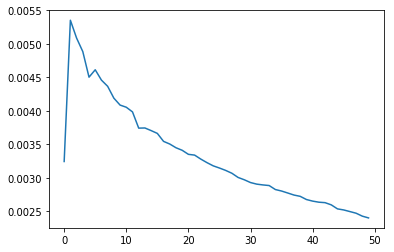

In [62]:
# Run truncated SVD on the dataset
from sklearn.decomposition import TruncatedSVD

num_svd_comp = 50
svd = TruncatedSVD(n_components=num_svd_comp, n_iter=7, random_state=42)
X_train_svd = svd.fit_transform(X_train)
X_val_svd = svd.transform(X_val)
print(np.sum(svd.explained_variance_ratio_))
sns.lineplot(x=list(range(num_svd_comp)), y=svd.explained_variance_ratio_)

In [63]:
from sklearn.manifold import TSNE
# model=TSNE(learning_rate=100)
# Tsne_transformed_train = model.fit_transform(X_train_svd)
# Tsne_transformed_val = model.fit_transform(X_val_svd)
# xs_train = Tsne_transformed_train[:,0]
# ys_train = Tsne_transformed_train[:,1]
# xs_val = Tsne_transformed_val[:,0]
# ys_val = Tsne_transformed_val[:,1]
# save_to_disk(xs_train, "tsne_x_train.pkl")
# save_to_disk(ys_train, "tsne_y_train.pkl")
# save_to_disk(xs_val, "tsne_x_val.pkl")
# save_to_disk(ys_val, "tsne_y_val.pkl")

In [64]:
xs_train = load_from_disk("./tsne_x_train.pkl")
ys_train = load_from_disk("./tsne_y_train.pkl")
xs_val = load_from_disk("./tsne_x_val.pkl")
ys_val = load_from_disk("./tsne_y_val.pkl")

[Text(0.5, 1.0, 'Ground truth: Val')]

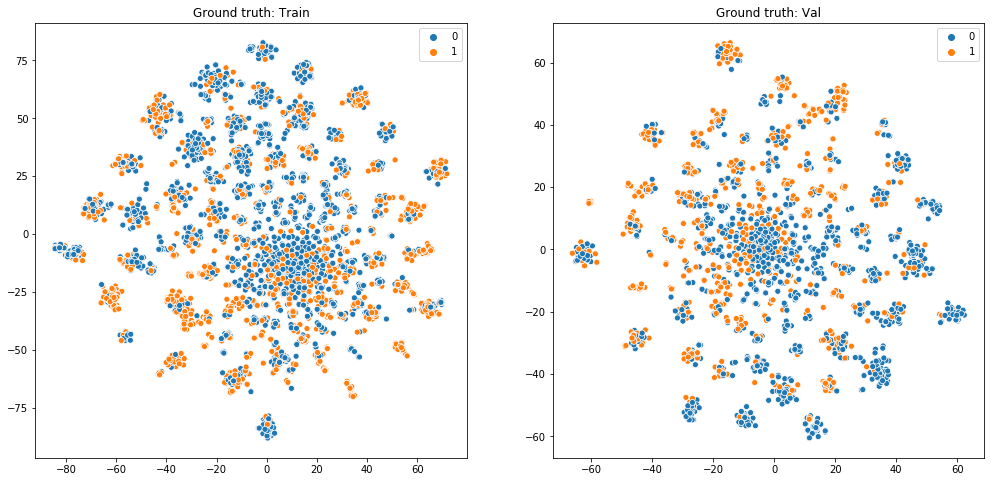

In [65]:
f, ax = plt.subplots(1,2,figsize=(17,8))
g = sns.scatterplot(xs_train,ys_train, hue=train_data[ycol].values.ravel(), ax=ax[0])
g.set(title="Ground truth: Train")
# g = sns.scatterplot(xs_train,ys_train, hue=train_ylabels, ax=ax[0][1], palette=rev_palette)
# g.set(title="Predicted: Train")
g = sns.scatterplot(xs_val,ys_val, hue=val_data[ycol].values.ravel(), ax=ax[1])
g.set(title="Ground truth: Val")
# g = sns.scatterplot(xs_val,ys_val, hue=val_ylabels, ax=ax[1][1], palette=rev_palette)
# g.set(title="Predicted: Val")

------

In [66]:
# Quick helper variable
classification_df = {
    "classifier":[],
    "training_acc":[],
    "val_acc":[]
}

------

# Logistic Regression - Baseline

In [67]:
logit = LogisticRegression()
logit.fit(X_train, train_data[ycol].values)

train_ylabels = logit.predict(X_train)

print(20*"=", "Training data", 20*"=")
print("Classification Reports ---\n\n")
print(classification_report(y_true=train_data[ycol].values, y_pred=train_ylabels))
print(55*"-")
print("confusion matrix ---")   
display(get_confusion_mat(train_data[ycol].values.ravel(), train_ylabels))

val_ylabels = logit.predict(X_val)

print(20*"=", "Test data", 20*"=")
print("Classification Reports ---\n\n")
print(classification_report(y_true=val_data['target'].values, y_pred=val_ylabels))
print(55*"-")
print("confusion matrix ---")   
display(get_confusion_mat(val_data['target'].values.ravel(), val_ylabels))


# Append info to the classification dictionary
classification_df["classifier"].append("LogReg_baseline")
classification_df["training_acc"].append(accuracy_score(y_true=train_data[ycol].values, y_pred=train_ylabels))
classification_df["val_acc"].append(accuracy_score(y_true=val_data[ycol].values, y_pred=val_ylabels))

==================== Training data ====================
Classification Reports ---


              precision    recall  f1-score   support

           0       0.83      0.93      0.88      3014
           1       0.90      0.75      0.82      2310

    accuracy                           0.85      5324
   macro avg       0.86      0.84      0.85      5324
weighted avg       0.86      0.85      0.85      5324

-------------------------------------------------------
confusion matrix ---


,Pred_0,Pred_1
True_0,2811,203
True_1,576,1734


==================== Test data ====================
Classification Reports ---


              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1324
           1       0.79      0.69      0.74       957

    accuracy                           0.79      2281
   macro avg       0.79      0.78      0.78      2281
weighted avg       0.79      0.79      0.79      2281

-------------------------------------------------------
confusion matrix ---


,Pred_0,Pred_1
True_0,1151,173
True_1,300,657


----

# Logistic Regression - Truncated SVD

In [68]:
logit = LogisticRegression()
logit.fit(X_train_svd, train_data[ycol].values)

train_ylabels = logit.predict(X_train_svd)

print(20*"=", "Training data", 20*"=")
print("Classification Reports ---\n\n")
print(classification_report(y_true=train_data[ycol].values, y_pred=train_ylabels))
print(55*"-")
print("confusion matrix ---")   
display(get_confusion_mat(train_data[ycol].values.ravel(), train_ylabels))

val_ylabels = logit.predict(X_val_svd)

print(20*"=", "Test data", 20*"=")
print("Classification Reports ---\n\n")
print(classification_report(y_true=val_data['target'].values, y_pred=val_ylabels))
print(55*"-")
print("confusion matrix ---")   
display(get_confusion_mat(val_data['target'].values.ravel(), val_ylabels))

# Append info to the classification dictionary
classification_df["classifier"].append("LogReg_SVD")
classification_df["training_acc"].append(accuracy_score(y_true=train_data[ycol].values, y_pred=train_ylabels))
classification_df["val_acc"].append(accuracy_score(y_true=val_data[ycol].values, y_pred=val_ylabels))

==================== Training data ====================
Classification Reports ---


              precision    recall  f1-score   support

           0       0.71      0.89      0.79      3014
           1       0.79      0.53      0.64      2310

    accuracy                           0.74      5324
   macro avg       0.75      0.71      0.71      5324
weighted avg       0.75      0.74      0.72      5324

-------------------------------------------------------
confusion matrix ---


,Pred_0,Pred_1
True_0,2684,330
True_1,1079,1231


==================== Test data ====================
Classification Reports ---


              precision    recall  f1-score   support

           0       0.72      0.89      0.79      1324
           1       0.77      0.52      0.62       957

    accuracy                           0.73      2281
   macro avg       0.74      0.70      0.71      2281
weighted avg       0.74      0.73      0.72      2281

-------------------------------------------------------
confusion matrix ---


,Pred_0,Pred_1
True_0,1172,152
True_1,460,497


------

# Logistic Regression - L1 regularization

In [69]:
lasso = LogisticRegression(penalty='l1', tol=1e-5)
lasso.fit(X_train, train_data[ycol].values)

train_ylabels = lasso.predict(X_train)

print(20*"=", "Training data", 20*"=")
print("Classification Reports ---\n\n")
print(classification_report(y_true=train_data[ycol].values, y_pred=train_ylabels))
print(55*"-")
print("confusion matrix ---")   
display(get_confusion_mat(train_data[ycol].values.ravel(), train_ylabels))

val_ylabels = lasso.predict(X_val)

print(20*"=", "Test data", 20*"=")
print("Classification Reports ---\n\n")
print(classification_report(y_true=val_data['target'].values, y_pred=val_ylabels))
print(55*"-")
print("confusion matrix ---")   
display(get_confusion_mat(val_data['target'].values.ravel(), val_ylabels))

# Append info to the classification dictionary
classification_df["classifier"].append("Lasso")
classification_df["training_acc"].append(accuracy_score(y_true=train_data[ycol].values, y_pred=train_ylabels))
classification_df["val_acc"].append(accuracy_score(y_true=val_data[ycol].values, y_pred=val_ylabels))

==================== Training data ====================
Classification Reports ---


              precision    recall  f1-score   support

           0       0.80      0.92      0.86      3014
           1       0.88      0.71      0.78      2310

    accuracy                           0.83      5324
   macro avg       0.84      0.81      0.82      5324
weighted avg       0.83      0.83      0.83      5324

-------------------------------------------------------
confusion matrix ---


,Pred_0,Pred_1
True_0,2783,231
True_1,680,1630


==================== Test data ====================
Classification Reports ---


              precision    recall  f1-score   support

           0       0.77      0.86      0.81      1324
           1       0.77      0.64      0.70       957

    accuracy                           0.77      2281
   macro avg       0.77      0.75      0.76      2281
weighted avg       0.77      0.77      0.77      2281

-------------------------------------------------------
confusion matrix ---


,Pred_0,Pred_1
True_0,1138,186
True_1,341,616


------

# SVM - non linear kernel

In [70]:
svc = SVC(probability=True, kernel='rbf', C=1)
svc = svc.fit(X=X_train, y=train_data[ycol].values.ravel())

train_ylabels = svc.predict(X_train)

print(20*"=", "Training data", 20*"=")
print("Classification Reports ---\n\n")
print(classification_report(y_true=train_data[ycol].values, y_pred=train_ylabels))
print(55*"-")
print("confusion matrix ---")   
display(get_confusion_mat(train_data[ycol].values.ravel(), train_ylabels))

val_ylabels = svc.predict(X_val)

print(20*"=", "Test data", 20*"=")
print("Classification Reports ---\n\n")
print(classification_report(y_true=val_data['target'].values, y_pred=val_ylabels))
print(55*"-")
print("confusion matrix ---")   
display(get_confusion_mat(val_data['target'].values.ravel(), val_ylabels))

# Append info to the classification dictionary
classification_df["classifier"].append("SVM")
classification_df["training_acc"].append(accuracy_score(y_true=train_data[ycol].values, y_pred=train_ylabels))
classification_df["val_acc"].append(accuracy_score(y_true=val_data[ycol].values, y_pred=val_ylabels))

==================== Training data ====================
Classification Reports ---


              precision    recall  f1-score   support

           0       0.57      1.00      0.72      3014
           1       0.00      0.00      0.00      2310

    accuracy                           0.57      5324
   macro avg       0.28      0.50      0.36      5324
weighted avg       0.32      0.57      0.41      5324

-------------------------------------------------------
confusion matrix ---


,Pred_0,Pred_1
True_0,3014,0
True_1,2310,0


==================== Test data ====================
Classification Reports ---


              precision    recall  f1-score   support

           0       0.58      1.00      0.73      1324
           1       0.00      0.00      0.00       957

    accuracy                           0.58      2281
   macro avg       0.29      0.50      0.37      2281
weighted avg       0.34      0.58      0.43      2281

-------------------------------------------------------
confusion matrix ---


,Pred_0,Pred_1
True_0,1324,0
True_1,957,0


----

In [71]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train, train_data[ycol])

train_ylabels = rf.predict(X_train)

print(20*"=", "Training data", 20*"=")
print("Classification Reports ---\n\n")
print(classification_report(y_true=train_data[ycol].values, y_pred=train_ylabels))
print(55*"-")
print("confusion matrix ---")   
display(get_confusion_mat(train_data[ycol].values.ravel(), train_ylabels))

val_ylabels = rf.predict(X_val)

print(20*"=", "Test data", 20*"=")
print("Classification Reports ---\n\n")
print(classification_report(y_true=val_data['target'].values, y_pred=val_ylabels))
print(55*"-")
print("confusion matrix ---")   
display(get_confusion_mat(val_data['target'].values.ravel(), val_ylabels))

# Append info to the classification dictionary
classification_df["classifier"].append("RF")
classification_df["training_acc"].append(accuracy_score(y_true=train_data[ycol].values, y_pred=train_ylabels))
classification_df["val_acc"].append(accuracy_score(y_true=val_data[ycol].values, y_pred=val_ylabels))

==================== Training data ====================
Classification Reports ---


              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3014
           1       0.99      0.97      0.98      2310

    accuracy                           0.98      5324
   macro avg       0.98      0.98      0.98      5324
weighted avg       0.98      0.98      0.98      5324

-------------------------------------------------------
confusion matrix ---


,Pred_0,Pred_1
True_0,2986,28
True_1,80,2230


==================== Test data ====================
Classification Reports ---


              precision    recall  f1-score   support

           0       0.78      0.83      0.80      1324
           1       0.74      0.69      0.71       957

    accuracy                           0.77      2281
   macro avg       0.76      0.76      0.76      2281
weighted avg       0.77      0.77      0.77      2281

-------------------------------------------------------
confusion matrix ---


,Pred_0,Pred_1
True_0,1094,230
True_1,301,656


----

# Random forest - hyperparameters tuned

In [51]:
# gsc = GridSearchCV(
#     n_jobs=1,
#     estimator=RandomForestClassifier(n_estimators=100, n_jobs=-1),
#     param_grid={
# #         'min_samples_split': [2,3,5],
#         'max_features': ['sqrt', 'log2', None],
#     },
#     cv=5
# )
# grid_result = gsc.fit(X_train, train_data[ycol].values.ravel())

# print("Best parameters : %s" % grid_result.best_params_)

Best parameters : {'max_features': 'log2'}


In [73]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_features='log2')
rf.fit(X_train, train_data[ycol])

train_ylabels = rf.predict(X_train)

print(20*"=", "Training data", 20*"=")
print("Classification Reports ---\n\n")
print(classification_report(y_true=train_data[ycol].values, y_pred=train_ylabels))
print(55*"-")
print("confusion matrix ---")   
display(get_confusion_mat(train_data[ycol].values.ravel(), train_ylabels))

val_ylabels = rf.predict(X_val)

print(20*"=", "Test data", 20*"=")
print("Classification Reports ---\n\n")
print(classification_report(y_true=val_data['target'].values, y_pred=val_ylabels))
print(55*"-")
print("confusion matrix ---")   
display(get_confusion_mat(val_data['target'].values.ravel(), val_ylabels))

# Append info to the classification dictionary
classification_df["classifier"].append("RF_tuned")
classification_df["training_acc"].append(accuracy_score(y_true=train_data[ycol].values, y_pred=train_ylabels))
classification_df["val_acc"].append(accuracy_score(y_true=val_data[ycol].values, y_pred=val_ylabels))

==================== Training data ====================
Classification Reports ---


              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3014
           1       0.99      0.96      0.98      2310

    accuracy                           0.98      5324
   macro avg       0.98      0.98      0.98      5324
weighted avg       0.98      0.98      0.98      5324

-------------------------------------------------------
confusion matrix ---


,Pred_0,Pred_1
True_0,2990,24
True_1,84,2226


==================== Test data ====================
Classification Reports ---


              precision    recall  f1-score   support

           0       0.78      0.85      0.81      1324
           1       0.76      0.66      0.71       957

    accuracy                           0.77      2281
   macro avg       0.77      0.75      0.76      2281
weighted avg       0.77      0.77      0.77      2281

-------------------------------------------------------
confusion matrix ---


,Pred_0,Pred_1
True_0,1125,199
True_1,326,631


----

# Summarize classifier performance

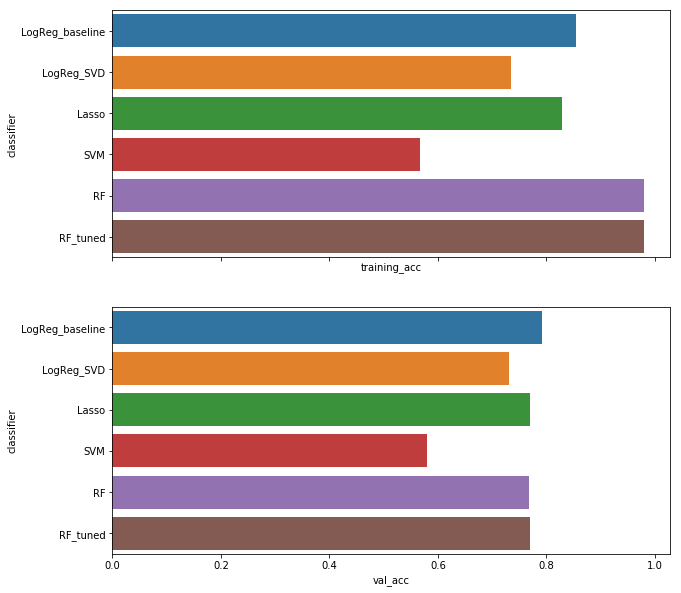

In [75]:
classification_df = pd.DataFrame(classification_df)

f, ax = plt.subplots(2, 1, figsize=(10,10), sharex=True)
g = sns.barplot(y="classifier", x="training_acc", data=classification_df, ax=ax[0])
g = sns.barplot(y="classifier", x="val_acc", data=classification_df, ax=ax[1])